# Stacking (*with an example using `scikit-learn`*)

When we construct a distributed 2D array in Bolt, we by default represent the values as one-dimensional arrays. While this is useful and generic, for some applications it is preferable to `stack` the values into larger arrays that we can operate on in parallel.

## How to stack

To do this kind of stacking, you can call `stack` on a distributed array and just provide the target size (as the number of records per stack)

In [1]:
from bolt import ones

In [2]:
a = ones((100, 5), sc)

Without stacking each record is an array of shape `(5,)`

In [3]:
a.tordd().values().first().shape

(5,)

But once we stack, each record has shape `(5,5)`

In [4]:
a.stack(5).tordd().values().first().shape

(5, 5)

Note that the "true" shape itself hasn't changed. This is important when keeping track of shape changes across operations.

In [5]:
a.stack(5).shape

(100, 5)

We can perform `map` operations over the stacked array. When we subsequently `unstack` it, shape information has been automatically propagated

In [6]:
a.stack(5).map(lambda x: x * 2).unstack().toarray().shape

(100, 5)

In [7]:
a.stack(5).map(lambda x: x.sum(axis=0)).unstack().toarray().shape

(20, 5)

## Use case with `scikit-learn`

As an example use case, we'll use `scikit-learn` to apply a model's `partial_fit` method in parallel.

First, make the data

In [8]:
from sklearn import datasets
X, y = datasets.make_blobs(n_samples=500, random_state=8)

In [9]:
X.shape

(500, 2)

Construct our Bolt array

In [10]:
from bolt import array

In [11]:
b = array(X, sc)

In [12]:
b.shape

(500, 2)

Stack the array

In [13]:
stacked = b.stack(10)

Create our model

In [14]:
from sklearn.cluster import MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=3)

And now call `partial_fit` on our stacked array

In [15]:
models = stacked.map(lambda x: km.partial_fit(x).cluster_centers_)
average = models.unstack().mean(axis=0)
centers = average.toarray()

Let's plot the result

In [16]:
%matplotlib inline

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

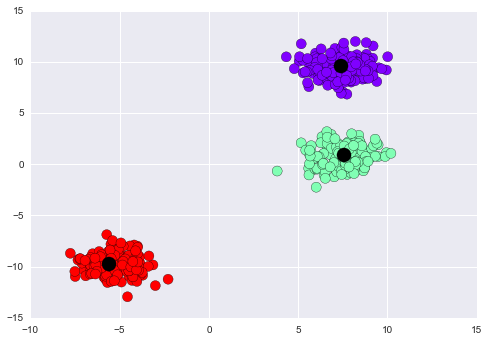

In [18]:
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap='rainbow');
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', cmap='rainbow');

NOTE: just because we're parallelizing doesn't mean we'll see a performance improvement! It will depend on the size of the data set, the size of the cluster, and the kind of operation, among other factors. One of the goals of Bolt is to make it easy to switch between local or distributed implementations, and use whichever one is faster with minimal code changes.

In this case, we could easily switch to use a local array

In [19]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)

In [20]:
model = km.fit(b.toarray())
centers = model.cluster_centers_

and get essentially the same answer

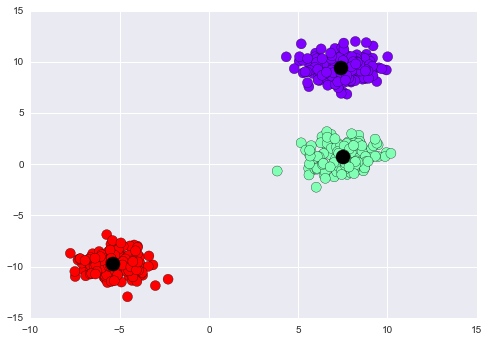

In [21]:
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap='rainbow');
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', cmap='rainbow');